We all know about the fact that cars depreciate. We also think that some class of cars (saloons vs SUV) and some brands perform better in retaining value.

I also know of these myths. But how true are they? I have 3 questions I want to answer:
1. Do SUVs depreciate less than saloon/estates?
2. Does doing less milage reduce depreciation?
3. Does having a car with a bigger engine reduce depreciation?
3. Do some brands depreciate less than others?

To answer these questions I have scraped data from a lot of car adds of the internet. Let's have a look at what it says

In [1]:
import pandas as pd
import numpy as np
import Database as db
import matplotlib.pyplot as plt
import seaborn as sns

connection = db.create_server_connection("localhost", "root", "Englezu1992!", "CarData_Jaguar")

df = pd.read_sql('SELECT * FROM Jaguar', con=connection)

df.head()

Connection to database CarData_Jaguar established.


,id,price,model,year,body,milage,engine_size,engine_power,transmission,fuel_type,owners,ultra_low_emissions_zone,service_history,first_year_road_tax,full_manufacturer_warranty,unexpected_value
0,1,59995,C-Type,2017,convertible,1000,4.2,1000000,manual,petrol,100,0,full service history,0,0,ok
1,2,25000,XK,2015,coupe,78000,5.0,503,automatic,petrol,3,1,unlisted,0,0,ok
2,3,67500,XK,2015,convertible,7000,5.0,503,automatic,petrol,100,1,unlisted,0,0,ok
3,4,43990,XK,2015,convertible,13269,5.0,385,automatic,petrol,2,1,unlisted,0,0,ok
4,5,29000,XJS,2017,convertible,37500,5.3,1000000,automatic,petrol,1,0,part service history,0,0,ok


First I want to limit the model at which I am looking. I don't want to look at cars which have a high prestige element to their pricing. The list of allowed models I have chosen is fully subjective.

I am also eliminating engines bigger than 4.4. L because there are not enough cars (17) to extract any meaningfull trend.

In [2]:
accepted_model_list = ['XK', 'XJS', 'XJ', 'XF', 'XE', 'I-Pace', 'F-Type',
                       'F-PACE', 'E-PACE']
df = df.loc[df['model'].isin(accepted_model_list)]
# df = df.loc[df['engine_size'] < 6]

df['model'].unique()

array(['XK', 'XJS', 'XJ', 'XF', 'XE', 'I-Pace', 'F-Type', 'F-PACE',
       'E-PACE'], dtype=object)

Next I want to fix a mistake I made when scraping. I have used some numbers instead of NaN to mark missing data and forgot to make the scraped check for when a car is brand new. But this can be easily identified in the data.

In [3]:
for idx, row in df.iterrows():
    if df.loc[idx,'milage'] == 1000000 and df.loc[idx,'year'] == 0 and df.loc[idx,'owners'] == 100:
        df.loc[idx,'milage'] = 0
        df.loc[idx,'year'] = 2022
        df.loc[idx,'owners'] = 0

Now let's correct some things I know are wrong with the data.
1. Removing the project 7 F-type convertible. It's not an ordinary car and this analysis is meant for ordinary cars, viewed more as utilities than luxury or prestige.
2. Removing the project 8 cars from saloons.
3. Removing Listers modified F-type.

In [4]:
#1
wrong_price_index = df.index[(df['body'] == 'convertible') & (df['price'] ==  149950)][0]
df = df.drop(wrong_price_index)
wrong_price_index = df.index[(df['body'] == 'convertible') & (df['price'] ==  139950)][0]
df = df.drop(wrong_price_index)
#2
wrong_price_index = df.index[(df['body'] == 'saloon') & (df['price'] ==  147403)][0]
df = df.drop(wrong_price_index)
wrong_price_index = df.index[(df['body'] == 'saloon') & (df['price'] ==  134844)][0]
df = df.drop(wrong_price_index)
wrong_price_index = df.index[(df['body'] == 'saloon') & (df['price'] ==  112950)][0]
df = df.drop(wrong_price_index)
wrong_price_index = df.index[(df['body'] == 'saloon') & (df['price'] ==  103000)][0]
df = df.drop(wrong_price_index)
#3
wrong_price_index = df.index[(df['body'] == 'suv') & (df['price'] ==  129990)][0]
df = df.drop(wrong_price_index)

In [5]:
df['body'].isna().sum()

0

First let's have a look at how model and body influence age induced depreciation

In [6]:
list_of_years = np.sort(df['year'].unique())
list_of_bodies = np.delete(df['body'].unique(),np.where(df['body'].unique()=='unlisted'))

age_depreciation_individual_year = pd.DataFrame(columns = ['Body','Year','Age depreciation'])

counter = 0

for body in list_of_bodies:
    for year in list_of_years:
        if year != 2022:
            future_year_mean = df.loc[(df['year'] == list_of_years[np.where(list_of_years == year)[0][0] + 1]) & (df['body'] == body)]['price'].mean()
            current_year_mean = df.loc[(df['year'] == year) & (df['body'] == body)]['price'].mean()
            difference = (future_year_mean - current_year_mean) / future_year_mean * 100
            if pd.notna(difference):
                age_depreciation_individual_year.loc[counter, 'Body'] = body
                age_depreciation_individual_year.loc[counter, 'Year'] = year
                age_depreciation_individual_year.loc[counter, 'Age depreciation'] = difference
                counter += 1
        else:
            next

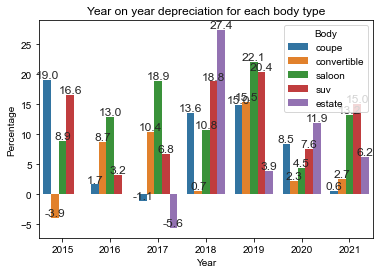

In [7]:
ax = sns.barplot(x = 'Year', y = 'Age depreciation', hue = 'Body', data = age_depreciation_individual_year)
sns.set(rc={'figure.figsize':(28,10)})
ax.set(title = 'Year on year depreciation for each body type', ylabel = 'Percentage')

for p in ax.patches:
    height = p.get_height()
    if pd.notna(height):
        ax.text(x = p.get_x()+(p.get_width()/2), y = height + 0.3, s = '{:.1f}'.format(height), ha = 'center')

In [8]:
list_of_years = np.sort(df['year'].unique())
list_of_bodies = np.delete(df['body'].unique(),np.where(df['body'].unique()=='unlisted'))
list_of_models = df['model'].unique()

age_depreciation_all_years = pd.DataFrame(columns = ['Model', 'Body', 'Age depreciation'])

counter = 0

for model in list_of_models:
    for body in list_of_bodies:
        original_value = df.loc[(df['model'] == model) & (df['year'] == 2021) & (df['body'] == body)]['price'].mean()
        depreciated_value = df.loc[(df['model'] == model) & (df['year'] == 2015) & (df['body'] == body)]['price'].mean()
        depreciation_percentage = (original_value - depreciated_value) / original_value * 100
        if pd.notna(depreciation_percentage):
            age_depreciation_all_years.loc[counter, 'Model'] = model
            age_depreciation_all_years.loc[counter, 'Body'] = body
            age_depreciation_all_years.loc[counter, 'Age depreciation'] = depreciation_percentage
            counter += 1

age_depreciation_all_years.head(20)

,Model,Body,Age depreciation
0,XJ,saloon,-63.437504
1,XF,saloon,62.472796
2,XF,estate,61.924427
3,XE,saloon,60.065824
4,F-Type,coupe,45.24153
5,F-Type,convertible,35.834411
6,F-PACE,suv,57.237366


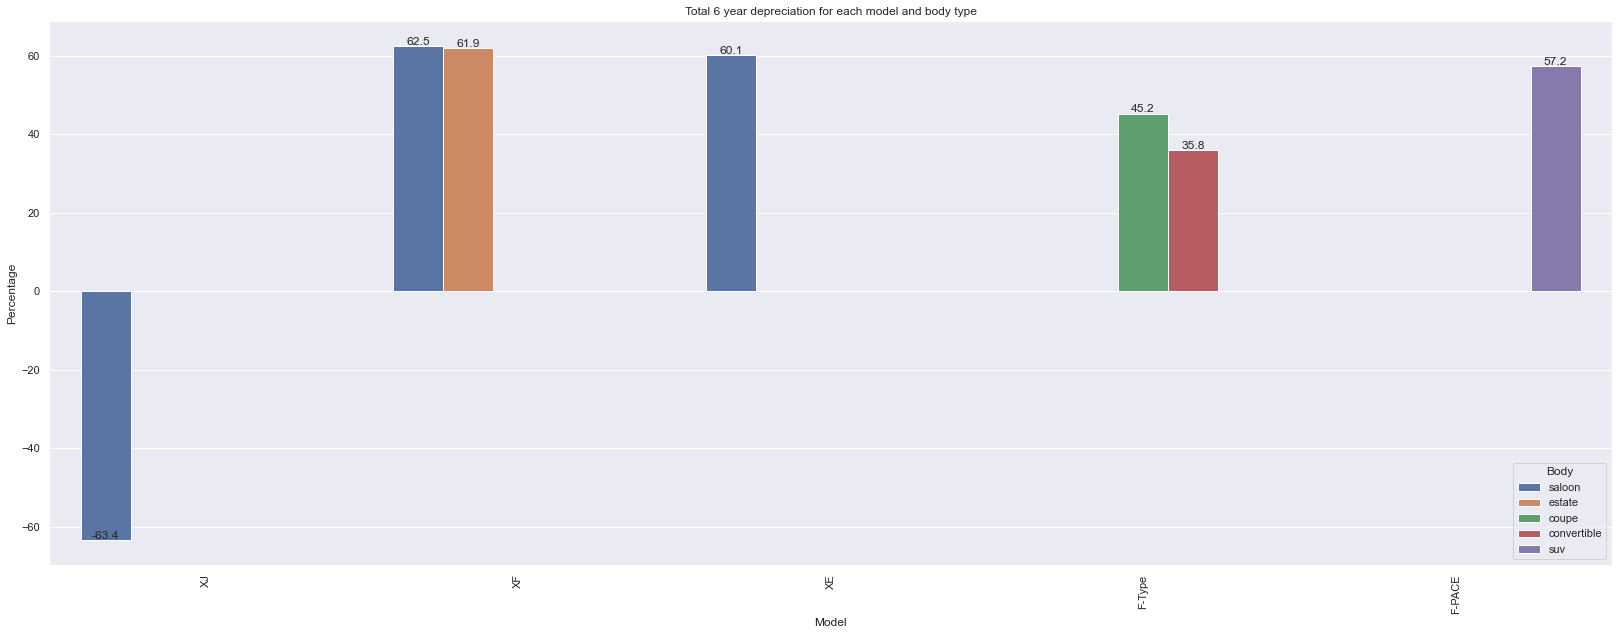

In [9]:
ax = sns.barplot(x = 'Model', y = 'Age depreciation', hue = 'Body', data = age_depreciation_all_years)
sns.set(rc={'figure.figsize':(28,10)})
ax.set(title = 'Total 6 year depreciation for each model and body type', ylabel = 'Percentage')

for p in ax.patches:
    height = p.get_height()
    if pd.notna(height):
        ax.text(x = p.get_x()+(p.get_width()/2), y = height + 0.3, s = '{:.1f}'.format(height), ha = 'center')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90);

Now let's have a look at how model and body influence model induced price difference.

In [10]:
list_of_years = np.sort(df['year'].unique())
list_of_bodies = np.delete(df['body'].unique(),np.where(df['body'].unique()=='unlisted'))

milage_depreciation_individual_year = pd.DataFrame(columns = ['Body','Year','Milage induced price difference'])

counter = 0

for body in list_of_bodies:
    for year in list_of_years:
        if year != 2022:
            filtered_df = df.loc[(df['body'] == body) & (df['year'] == year)]
            low_milage_mean = filtered_df.loc[filtered_df['milage'] < filtered_df['milage'].mean()]['price'].mean()
            high_milage_mean = filtered_df.loc[filtered_df['milage'] > filtered_df['milage'].mean()]['price'].mean()
            percentage_difference = (low_milage_mean - high_milage_mean) / low_milage_mean * 100
            if pd.notna(percentage_difference):
                milage_depreciation_individual_year.loc[counter, 'Body'] = body
                milage_depreciation_individual_year.loc[counter, 'Year'] = year
                milage_depreciation_individual_year.loc[counter, 'Milage induced price difference'] = percentage_difference
                counter += 1
        else:
            next

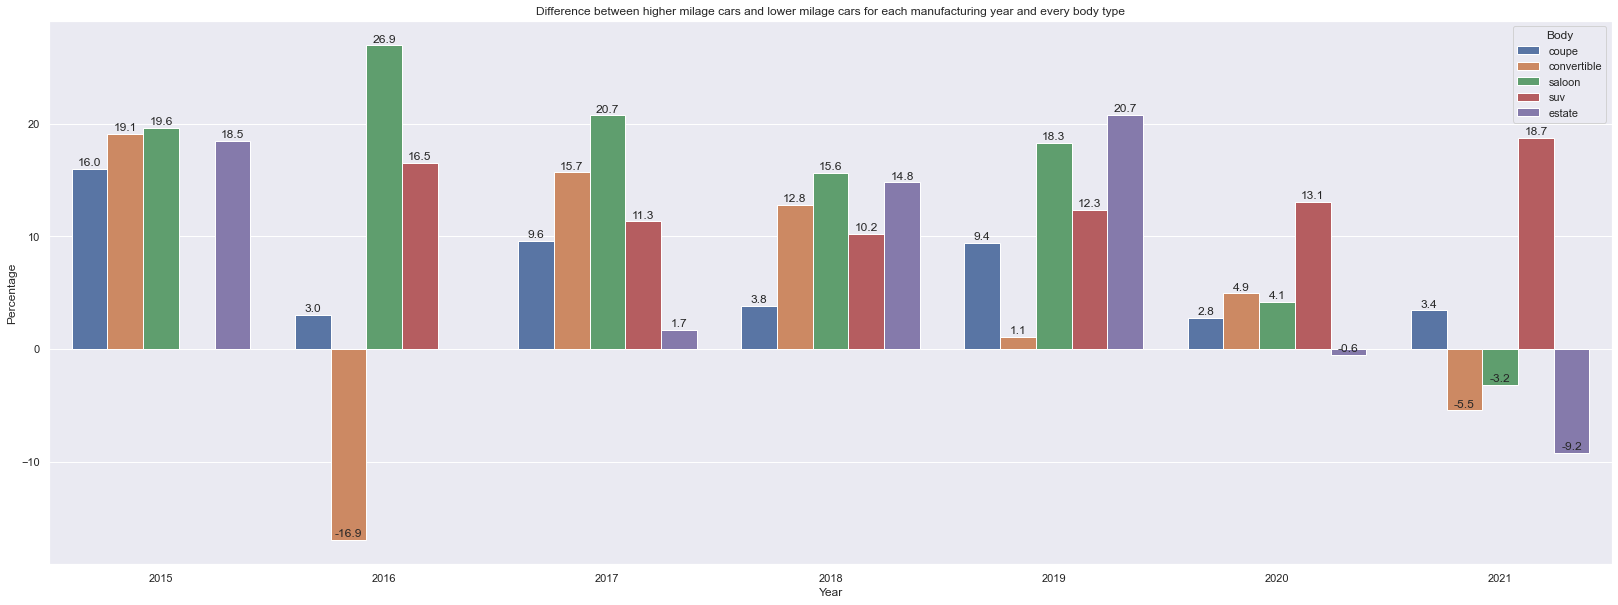

In [11]:
ax = sns.barplot(x = 'Year', y = 'Milage induced price difference', hue = 'Body', data = milage_depreciation_individual_year)
sns.set(rc={'figure.figsize':(28,10)})
ax.set(title = 'Difference between higher milage cars and lower milage cars for each manufacturing year and every body type', ylabel = 'Percentage')

for p in ax.patches:
    height = p.get_height()
    if pd.notna(height):
        ax.text(x = p.get_x()+(p.get_width()/2), y = height + 0.3, s = '{:.1f}'.format(height), ha = 'center')

In [12]:
list_of_years = np.sort(df['year'].unique())
list_of_bodies = np.delete(df['body'].unique(),np.where(df['body'].unique()=='unlisted'))
list_of_models = df['model'].unique()

milage_depreciation_all_years = pd.DataFrame(columns = ['Model', 'Body','Milage induced price difference'])

counter = 0

for model in list_of_models:
    for body in list_of_bodies:
        acumulator = 0
        corrector = 0
        for year in list_of_years:
            filtered_df = df.loc[(df['model'] == model) & (df['body'] == body) & (df['year'] == year)]
            low_milage_mean = filtered_df.loc[filtered_df['milage'] < filtered_df['milage'].mean()]['price'].mean()
            high_milage_mean = filtered_df.loc[filtered_df['milage'] > filtered_df['milage'].mean()]['price'].mean()
            if pd.notna(low_milage_mean) and pd.notna(high_milage_mean):
                percentage_difference = (low_milage_mean - high_milage_mean) / low_milage_mean * 100
                acumulator += percentage_difference
            else:
                corrector += 1
        if (len(list_of_years) - corrector) > 0:
            percentage_difference = acumulator / (len(list_of_years) - corrector)
            milage_depreciation_all_years.loc[counter, 'Model'] = model
            milage_depreciation_all_years.loc[counter, 'Body'] = body
            milage_depreciation_all_years.loc[counter, 'Milage induced price difference'] = percentage_difference
            counter += 1
        elif (len(list_of_years) - corrector) < 0:
            print('Acumulator: ', acumulator,', Corrector: ', corrector)
        else:
            pass

milage_depreciation_all_years.head(20)

,Model,Body,Milage induced price difference
0,XK,convertible,34.82963
1,XJ,saloon,23.958702
2,XF,saloon,9.847602
3,XF,estate,7.236068
4,XE,saloon,14.107082
5,I-Pace,suv,3.022549
6,F-Type,coupe,6.469554
7,F-Type,convertible,2.47902
8,F-PACE,suv,8.351537
9,E-PACE,suv,2.066259


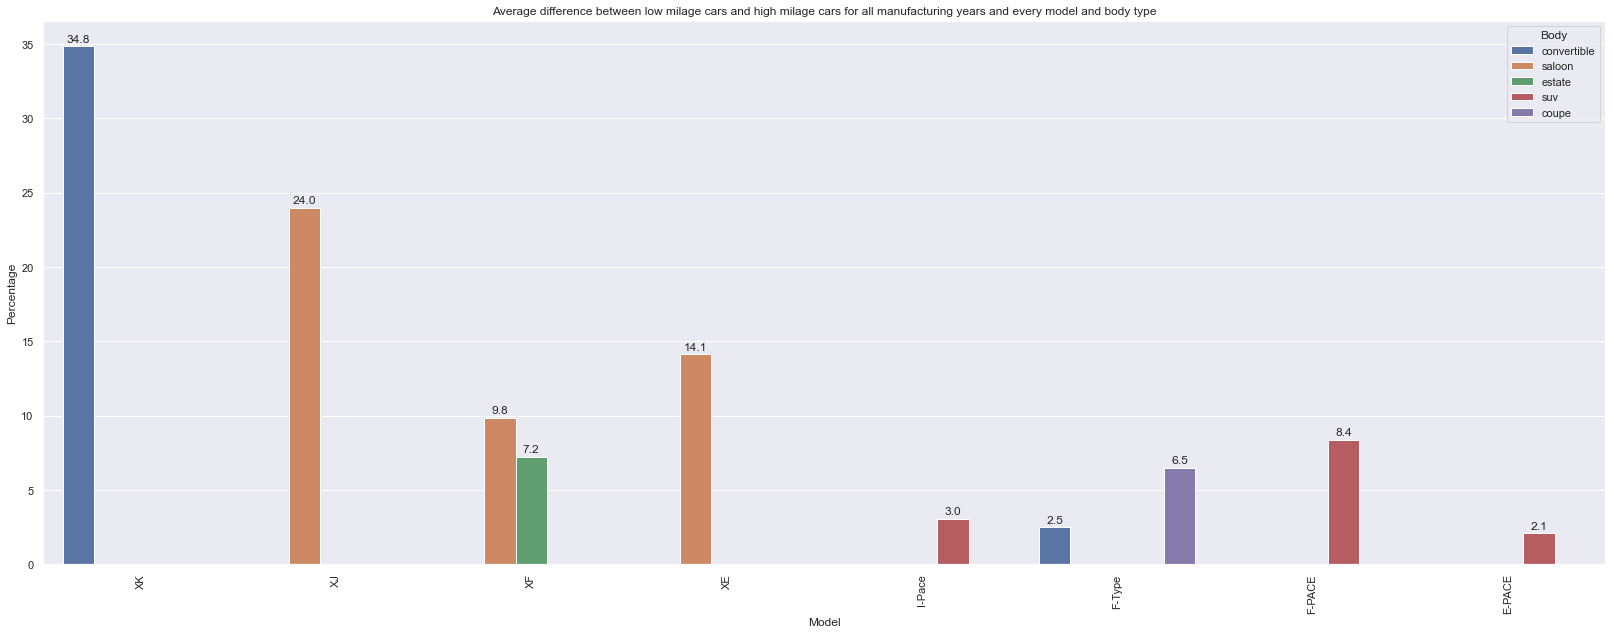

In [13]:
ax = sns.barplot(x = 'Model', y = 'Milage induced price difference', hue = 'Body', data = milage_depreciation_all_years)
sns.set(rc={'figure.figsize':(28,10)})
ax.set(title = 'Average difference between low milage cars and high milage cars for all manufacturing years and every model and body type', ylabel = 'Percentage')

for p in ax.patches:
    height = p.get_height()
    if pd.notna(height):
        ax.text(x = p.get_x()+(p.get_width()/2), y = height + 0.3, s = '{:.1f}'.format(height), ha = 'center')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90);

Now lets have a look at the influence of engine size on age and milage depreciation

In [14]:
list_of_years = np.sort(df['year'].unique())
list_of_bodies = np.delete(df['body'].unique(),np.where(df['body'].unique()=='unlisted'))
list_of_engine_sizes = np.sort(np.delete(df['engine_size'].unique(), np.where(df['engine_size'].unique() == 50)))

age_depreciation_all_years_and_engines = pd.DataFrame(columns = ['Body', 'Engine size', 'Age depreciation'])

counter = 0

for body in list_of_bodies:
    for engine in list_of_engine_sizes:
        original_value = df.loc[(df['engine_size'] == engine) & (df['year'] == 2021) & (df['body'] == body)]['price'].mean()
        depreciated_value = df.loc[(df['engine_size'] == engine) & (df['year'] == 2015) & (df['body'] == body)]['price'].mean()
        if pd.notna(original_value) and pd.notna(depreciated_value):
            body_index = np.where(list_of_bodies == body)[0][0]
            depreciation_percentage = (original_value - depreciated_value) / original_value * 100
            age_depreciation_all_years_and_engines.loc[counter, 'Body'] = body
            age_depreciation_all_years_and_engines.loc[counter, 'Engine size'] = engine
            age_depreciation_all_years_and_engines.loc[counter, 'Age depreciation'] = depreciation_percentage
            counter += 1

age_depreciation_all_years_and_engines.head(20)

,Body,Engine size,Age depreciation
0,coupe,3.0,45.091356
1,coupe,5.0,39.034078
2,convertible,3.0,37.61059
3,convertible,5.0,26.58399
4,saloon,2.0,61.793354
5,saloon,3.0,56.238021
6,suv,2.0,47.118766


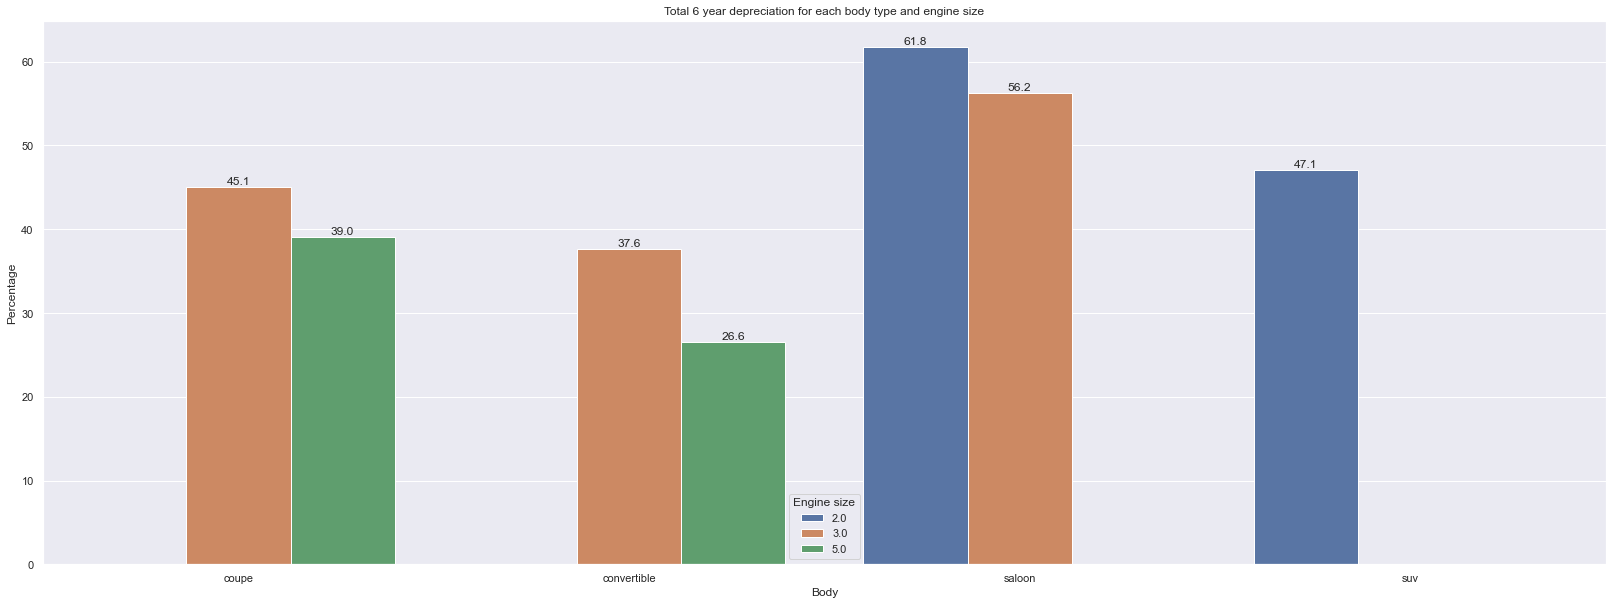

In [15]:
ax = sns.barplot(x = 'Body', y = 'Age depreciation', hue = 'Engine size', data = age_depreciation_all_years_and_engines)
sns.set(rc={'figure.figsize':(28,10)})
ax.set(title = 'Total 6 year depreciation for each body type and engine size', ylabel = 'Percentage')

for p in ax.patches:
    height = p.get_height()
    if pd.notna(height):
        ax.text(x = p.get_x()+(p.get_width()/2), y = height + 0.3, s = '{:.1f}'.format(height), ha = 'center')

In [16]:
list_of_years = np.sort(df['year'].unique())
list_of_bodies = np.delete(df['body'].unique(),np.where(df['body'].unique()=='unlisted'))
list_of_engine_sizes = np.sort(np.delete(df['engine_size'].unique(), np.where(df['engine_size'].unique() == 50)))

milage_depreciation_all_years = pd.DataFrame(columns = ['Body', 'Engine size', 'Milage induced price difference'])

counter = 0

for body in list_of_bodies:
    for engine in list_of_engine_sizes:
        acumulator = 0
        corrector = 0
        for year in list_of_years:
            filtered_df = df.loc[(df['engine_size'] == engine) & (df['year'] == year) & (df['body'] == body)]
            low_milage_mean = filtered_df.loc[filtered_df['milage'] < filtered_df['milage'].mean()]['price'].mean()
            high_milage_mean = filtered_df.loc[filtered_df['milage'] > filtered_df['milage'].mean()]['price'].mean()
            if pd.notna(low_milage_mean) and pd.notna(high_milage_mean):
                percentage_difference = (low_milage_mean - high_milage_mean) / low_milage_mean * 100
                acumulator += percentage_difference
            else:
                corrector += 1
        if (len(list_of_years) - corrector) > 0:
            percentage_difference = acumulator / (len(list_of_years) - corrector)
            milage_depreciation_all_years.loc[counter, 'Engine size'] = engine
            milage_depreciation_all_years.loc[counter, 'Body'] = body
            milage_depreciation_all_years.loc[counter, 'Milage induced price difference'] = percentage_difference
            counter += 1
        elif (len(list_of_years) - corrector) < 0:
            print('Acumulator: ', acumulator,', Corrector: ', corrector)
        else:
            pass

milage_depreciation_all_years.head(20)

,Body,Engine size,Milage induced price difference
0,coupe,2.0,6.516814
1,coupe,3.0,6.948217
2,coupe,5.0,6.50908
3,convertible,2.0,0.558855
4,convertible,3.0,4.642664
5,convertible,5.0,10.071549
6,saloon,2.0,11.942503
7,saloon,2.2,20.720591
8,saloon,3.0,20.7248
9,saloon,5.0,8.332435


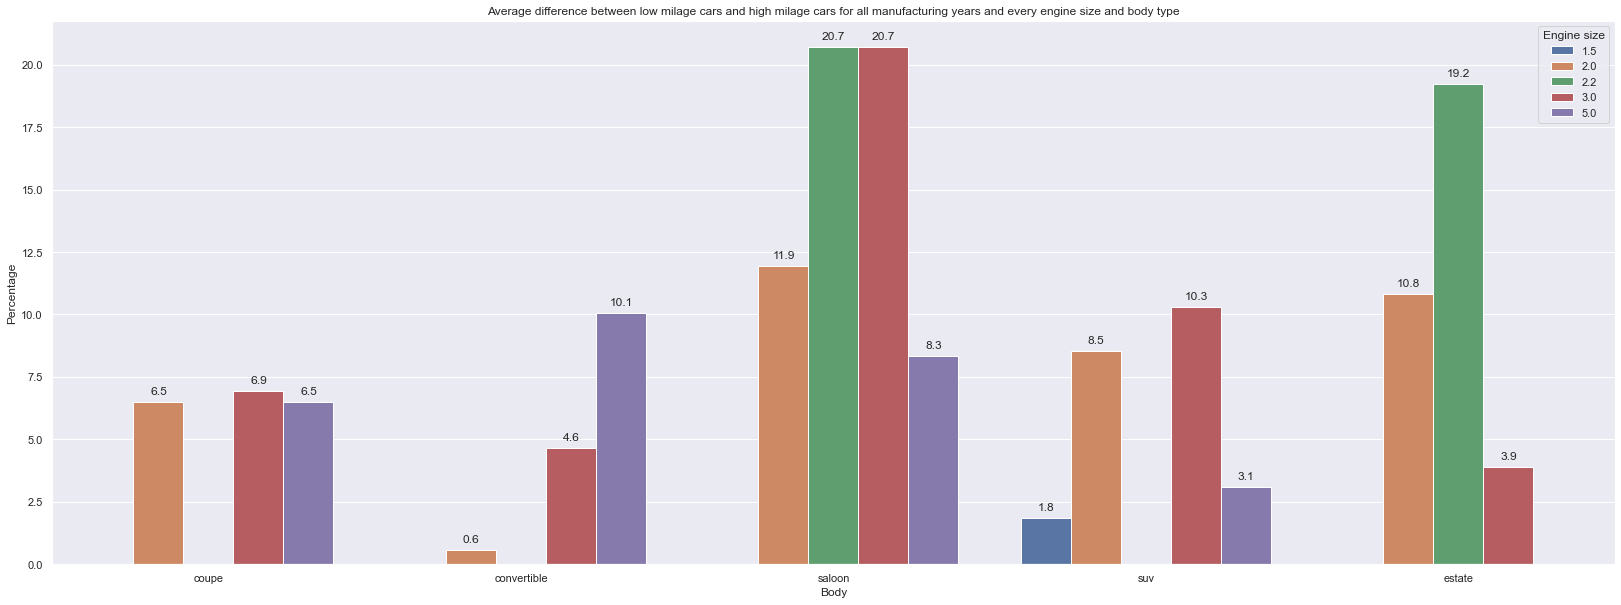

In [17]:
ax = sns.barplot(x = 'Body', y = 'Milage induced price difference', hue = 'Engine size', data = milage_depreciation_all_years)
sns.set(rc={'figure.figsize':(28,10)})
ax.set(title = 'Average difference between low milage cars and high milage cars for all manufacturing years and every engine size and body type', ylabel = 'Percentage')

for p in ax.patches:
    height = p.get_height()
    if pd.notna(height):
        ax.text(x = p.get_x()+(p.get_width()/2), y = height + 0.3, s = '{:.1f}'.format(height), ha = 'center')